In this notebook, I develop code to produce an animation of the mouse with the video, and some signals overlayed.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, patches
from scipy import signal
from tqdm.auto import tqdm

from tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.data_analysis.Utilities import filters
from tbd_eeg.data_analysis.Utilities.behavior_movies import Movie

%matplotlib inline

In [2]:
def median_amplitude(data):
    peaks, _ = signal.find_peaks(data.abs().values[:2000*300], distance=2000*0.01)
    return np.median(data.abs().values[peaks][:2000*300])

def normalize_spec(Sxx):
    Sxx_min = Sxx.min(axis=1)
    Sxx_max = Sxx.max(axis=1)
    return (Sxx - Sxx_min[:, np.newaxis]) / (Sxx_max[:, np.newaxis] - Sxx_min[:, np.newaxis])

def find_hf_annotations(data_ch, sample_rate=2000, nperseg=2048, fmin=200, power=0.2):
    f, t, Sxx = signal.spectrogram(data_ch, sample_rate, nperseg=nperseg)
    Sxx_norm = normalize_spec(Sxx)
    frhinds = f > fmin
    t = t + data_ch.index[0]
    return pd.Series(data=(Sxx_norm[frhinds, :]>power).sum(axis=0), index=t, name='artifact')

def get_windows(annots, coalesce=0):
    '''
    annots: series with binary annotations
    coalesce: merge windows with separation less than this value
    '''
    wins = []
    th_old = 0
    new_win = True
    for i, tl in enumerate(annots.index):
        if th_old > tl:
            continue
        if annots[tl]:
            if tl <= th_old + coalesce:
                new_win = False
            else:
                new_win = True
            for th in annots.index[annots.index>tl]:
                if annots[th]:
                    pass
                else:
                    if new_win:
                        wins.append((annots.index[i-1], th))
                    else:
                        wins[-1] = (wins[-1][0], th)
                    th_old = th
                    break
    return wins

# Load and pipeline data

In [3]:
data_folder = r"/allen/programs/braintv/workgroups/nc-ophys/Leslie/eeg_pilot/mouse505550/pilot1_2020-03-02_10-08-51/recording1/"
bodycam_filepath = r"/allen/programs/braintv/workgroups/nc-ophys/Leslie/eeg_pilot/mouse505550/pilot1_2020-03-02_10-08-51/recording1/200302100833-0.avi"
sync_file = r"/allen/programs/braintv/workgroups/nc-ophys/Leslie/eeg_pilot/mouse505550/pilot1_2020-03-02_10-08-51/recording1/mouse505550_pilot1_200302_100826.sync"
exp = EEGexp(data_folder)

print('Loading data...')
eegdata = exp.memmap_EEGdata()
timestamps = np.load(exp.eegtimestamps_file)
eegdata = pd.DataFrame(data=eegdata, index=timestamps)

print('Applying low pass filter...')
eegdata = eegdata.apply(
    lambda x: filters.butter_filter(
        np.expand_dims(x, 1),
        sampling_frequency=exp.sample_rate,
        cutoff_frequency=1000,
        filter_order=2,
        ftype='low'
    )[:, 0], raw=True, axis=0
)

print('Downsampling...')
eegdata = eegdata[::int(exp.sample_rate/2000)]

print('Loading other data...')
sync_data = exp.load_sync_dataset()
linear_velocity, runtime = exp.load_running(sync_data)
running_speed = pd.Series(index=runtime, data=linear_velocity, name='speed')
try:
    iso_level, isotime = exp.load_analog_iso(sync_data)
    iso = pd.Series(index=isotime, data=iso_level, name='iso')
except:
    pass

print('Locating valid channels...')
median_amplitude = eegdata.apply(median_amplitude, axis=0)
active_channels = median_amplitude.index[median_amplitude < 1500]

print('Annotating artifacts...')
hf_annots = pd.Series(eegdata[active_channels].apply(find_hf_annotations, axis=0, fmin=300, power=0.3).mean(axis=1), name='artifact')

sync_ch = 'behavior_camera'
bodymovie = Movie(
    filepath=bodycam_filepath,
    sync_filepath=sync_file,
    sync_channel=sync_ch
)

print('Done')

Loading data...
Loading /allen/programs/braintv/workgroups/nc-ophys/Leslie/eeg_pilot/mouse505550/pilot1_2020-03-02_10-08-51/recording1/continuous/Rhythm_FPGA-111.0/continuous.dat
Applying low pass filter...
Downsampling...
Loading other data...


/home/saurabh.gandhi/Projects/.env_zz/lib/python3.7/site-packages/allensdk/brain_observatory/sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


Locating valid channels...
Annotating artifacts...
Done


# Build the frame

In [4]:
def generate_frame(T, frames, ts_list, event_list, color_cycle, t_win=10, f=None):
    '''
    T: time to plot at
    ts_list: list of pandas Series objects to plot as timeseries
    event_list: list of pandas Series (boolean) objects to display as on/off
    color_cycle: list of colors for the above items (length must be greater than the above lists)
    t_win: length of window to show in the timeseries plot
    '''
    if f is None:
        f = plt.figure(figsize=(8, 6))
    axes = {}
    z = 0
    
    axes['image'] = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], zorder=z)
    z += 1
    axes['image'].imshow(frames.get_frame(time=T))
    axes['image'].annotate('t = {0:.2f} s'.format(T), (0.01, 0.99), xycoords='axes fraction', va='top', c='white')

    for i, ts in enumerate(ts_list):
        axes[ts.name] = plt.axes([0, 0.15*i, 1, 0.15], fc=cm.Greys(0, 0), frame_on=False, zorder=z, xticks=[], yticks=[], xlim=(T-t_win/2, T+t_win/2))
        z += 1
        try:
            ts[(ts.index>T-t_win/2)&(ts.index<T+t_win/2)].plot(
                ax=axes[ts.name], c=color_cycle[i], legend=False
            )
        except:
            pass
        axes[ts.name].annotate(ts.name, (0.01, 0.9), xycoords='axes fraction', color=color_cycle[i], va='top', fontsize=14)
        axes[ts.name].axvline(T, c='r')
#         axes[ts.name].set_xlim(T-t_win/2, T+t_win/2)

    for i, ts in enumerate(event_list):
        axes[ts.name] = plt.axes([0.9, 1-0.2*(i+1), 0.1, 0.13], fc=cm.Greys(0, 0), frame_on=False, zorder=z, xticks=[], yticks=[])
        z += 1
        event_patch = patches.Circle((0.5, 0.7), radius=0.25, color=color_cycle[i], transform=axes[ts.name].transAxes)
        if not ts.reindex([T], method='nearest').iloc[0]:
            event_patch = patches.Circle((0.5, 0.7), radius=0.25, color=cm.Greys(0.1, 0.4), transform=axes[ts.name].transAxes)
        axes[ts.name].add_artist(event_patch)
        axes[ts.name].annotate(ts.name, (0.5, 0.38), xycoords='axes fraction', ha='center', va='top', color=color_cycle[i], fontsize=14)
    
    return f, axes

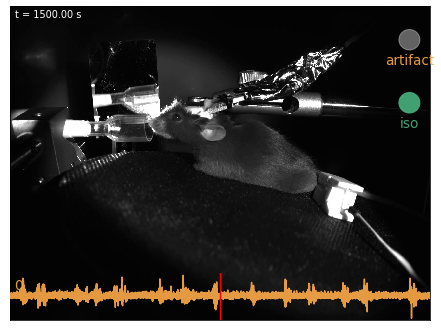

In [5]:
# length of time window to show in seconds
t_win = 60

# list of data pd.Series, indexed by time
ts_list = [
    eegdata[0],
]

# list of boolean pd.Series, indexed by time
event_list = [
    pd.Series(hf_annots>10),
    iso>iso.mean(),
]

# list of colors for the above data overlays
color_cycle = [cm.YlOrRd(0.4, 0.9), cm.BuGn(0.6, 0.9)]

f, axes = generate_frame(1500, bodymovie, ts_list, event_list, color_cycle, t_win=t_win, f=plt.figure(figsize=(6, 4.5), dpi=70))

# Export animation

## Export images / memmapped array

In [6]:
from PIL import Image
import gc
from matplotlib import animation

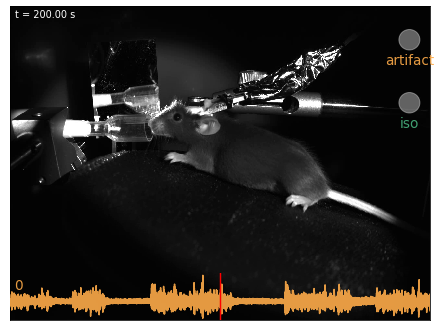

In [7]:
fig, axes = generate_frame(200, bodymovie, ts_list, event_list, color_cycle, t_win=t_win, f=plt.figure(figsize=(6, 4.5), dpi=70))
fig.canvas.draw()
data = np.array(fig.canvas.renderer.buffer_rgba())

In [8]:
data.shape

(315, 420, 4)

In [9]:
FPS = 20
T_START = 2950
T_STOP = 3050

fname = '../data/eeg/animation/505550_{0:d}_{1:d}.npy'.format(T_START, T_STOP)
imdata = np.memmap(fname, mode='w+', shape=(int(T_STOP-T_START)*FPS, *data.shape), dtype='uint8')

In [10]:
t_win = 10
plt.ioff()
gc.collect()
for i, t in enumerate(tqdm(np.arange(T_START, T_STOP, 1/FPS))):
#     if i < 50:
#         print(i, t)
    fig, axes = generate_frame(t, bodymovie, ts_list, event_list, color_cycle, t_win=t_win, f=plt.figure(figsize=(6, 4.5), dpi=70))
    fig.canvas.draw()
    imdata[i] = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

In [11]:
# # test images
# # imdata = np.memmap(fname, mode='r', shape=(int(T_STOP-T_START)*FPS, *data.shape))

# fig = plt.figure()
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
# ax = fig.add_subplot(111)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# im = ax.imshow(imdata[1])

In [12]:
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax = fig.add_subplot(111)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
im = ax.imshow(np.zeros(imdata.shape[1:]))

def update_img(n):
    im.set_data(imdata[n])
    return im

ani = animation.FuncAnimation(fig, update_img, imdata.shape[0], interval=1000/FPS)
writer = animation.FFMpegWriter(fps=FPS)

ani.save(fname.replace('npy', 'mp4'), writer=writer)
plt.close()

if False:
    return ani.to_html5_video()

## Using matplotlib animation class

In [6]:
from celluloid import Camera
from IPython.display import HTML

In [7]:
FPS = 20
T_START = 650
T_STOP = 750

/home/saurabh.gandhi/Projects/.env_zz/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/saurabh.gandhi/Projects/.env_zz/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


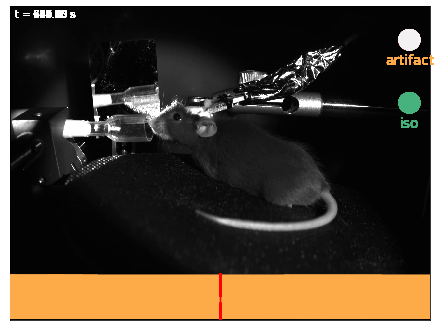

In [8]:
fig = plt.figure(figsize=(6, 4.5), dpi=70)

camera = Camera(fig)

# length of time window to show in seconds
t_win = 60

# list of data pd.Series, indexed by time
ts_list = [
    eegdata[0],
]

# list of boolean pd.Series, indexed by time
event_list = [
    pd.Series(hf_annots>10),
    iso>iso.mean(),
]

# list of colors for the above data overlays
color_cycle = [cm.YlOrRd(0.4, 0.9), cm.BuGn(0.6, 0.9)]

for t in tqdm(eegdata.reindex(np.arange(T_START, T_STOP, 1/FPS), method='nearest').index):
    fig, axes = generate_frame(t, bodymovie, ts_list, event_list, color_cycle, t_win=t_win, f=fig)
    camera.snap()

In [9]:
animation = camera.animate(interval=1000/FPS)

In [ ]:
animation.save('../data/eeg/animation/test_505550.mp4')

In [ ]:
import gc
for i in tqdm(range(int(eegdata.index.max()/600)+1)):
    gc.collect()
    T_START = i*600
    T_STOP = (i+1)*600
    for t in eegdata.reindex(np.arange(T_START, T_STOP, 1/FPS), method='nearest').index:
        fig, axes = generate_frame(t, bodymovie, ts_list, event_list, color_cycle, t_win=t_win, f=fig)
        camera.snap()
    animation = camera.animate(interval=1000/FPS)
    animation.save('../data/eeg/animation/505550_{:d}.mp4'.format(i))

In [ ]:
# HTML(animation.to_html5_video())